# TME 7 : Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [2]:
from math import *

def quantize(I, k):
    """ float -> int 
    """
    if I==1:
        return k-1
    else:
        return int(I*k)

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [3]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    Iq=np.zeros((I.shape)).astype(int)
    for i in range (Iq.shape[0]):
        for j in range (Iq.shape[1]):
            Iq[i,j,0]=quantize(I[i,j,0], nH)
            Iq[i,j,1]=quantize(I[i,j,1], nS)
            Iq[i,j,2]=quantize(I[i,j,2], nV)
    
    hist=np.zeros((nH, nS, nV))
    
    for i in range(Iq.shape[0]):
        for j in range(Iq.shape[1]):
            hist[Iq[i,j,0],Iq[i,j,1],Iq[i,j,2]]+=1
            
    return Iq,hist

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


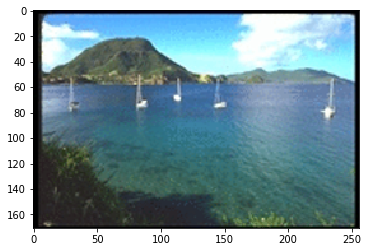

239.0625


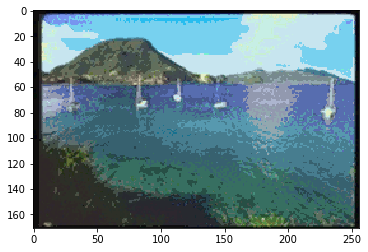

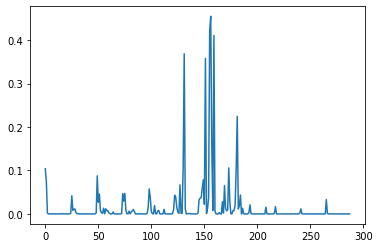

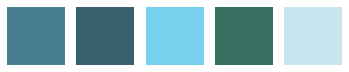

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [5]:
def testHSVHistogram(nH,nS,nV,PathImage,nom):
    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    plt.figure();
    plt.imshow(I);
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq , palette2)

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = normalize(histo)

    plt.figure()
    plt.plot(histo)
    plt.show()

    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

    display5mainColors(histo, palette)

    print(hsv_most_prevalent)


testHSVHistogram(12,3,8,'./Base/','Paysages67.png')


6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

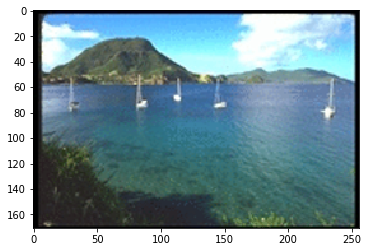

239.0625


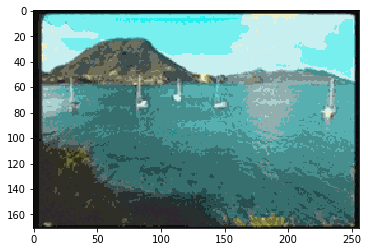

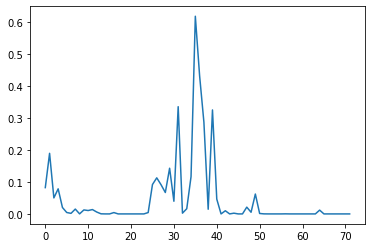

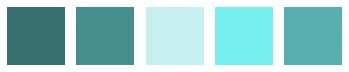

[(1, 1, 3), (1, 1, 4), (1, 0, 7), (1, 1, 7), (1, 1, 5)]


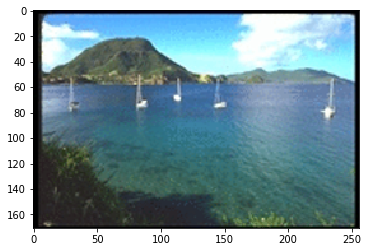

239.0625


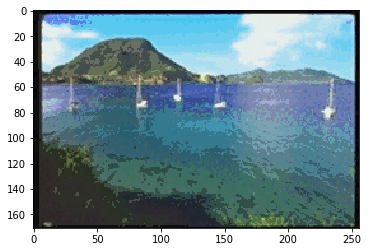

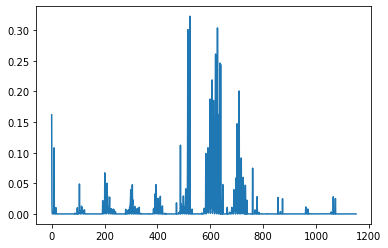

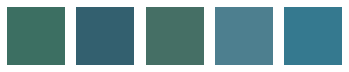

[(5, 5, 3), (6, 6, 3), (5, 4, 3), (6, 5, 4), (6, 7, 4)]


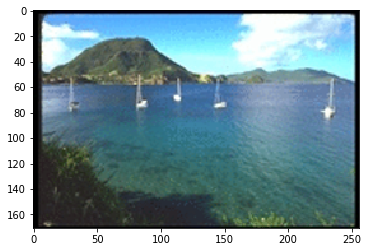

212.49999999999997


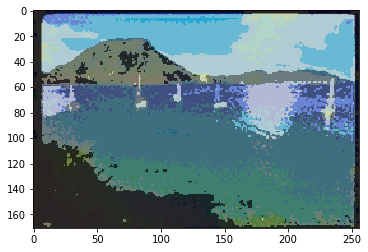

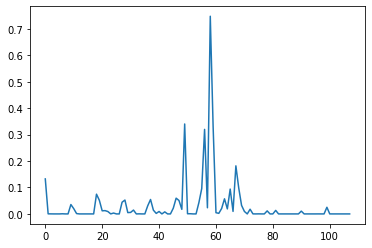

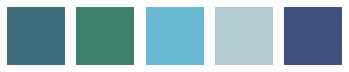

[(6, 1, 1), (5, 1, 1), (6, 1, 2), (6, 0, 2), (7, 1, 1)]


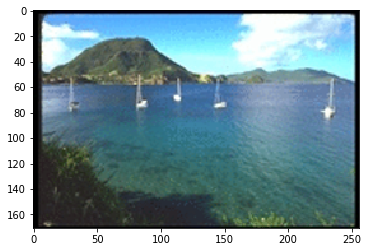

248.625


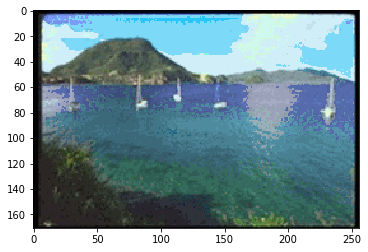

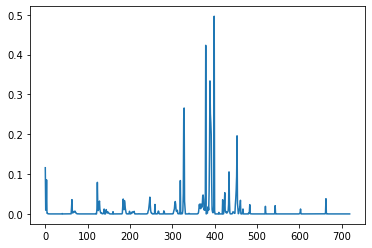

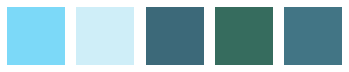

[(6, 1, 19), (6, 0, 19), (6, 1, 9), (5, 1, 8), (6, 1, 10)]


In [6]:
testHSVHistogram(3,3,8,'./Base/','Paysages67.png')
testHSVHistogram(12,12,8,'./Base/','Paysages67.png')
testHSVHistogram(12,3,3,'./Base/','Paysages67.png')
testHSVHistogram(12,3,20,'./Base/','Paysages67.png')

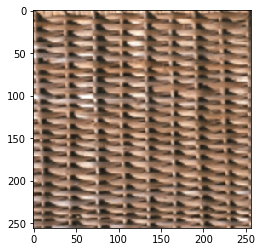

239.0625


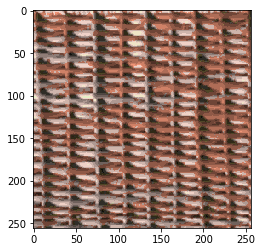

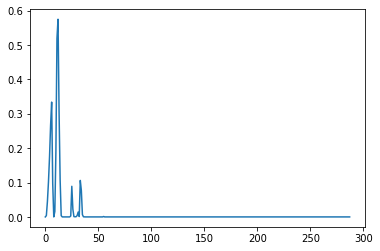

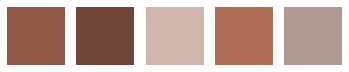

[(0, 1, 4), (0, 1, 3), (0, 0, 6), (0, 1, 5), (0, 0, 5)]


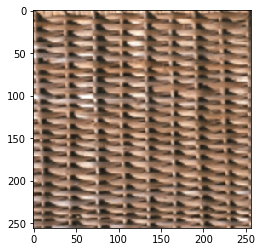

239.0625


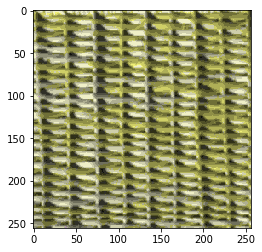

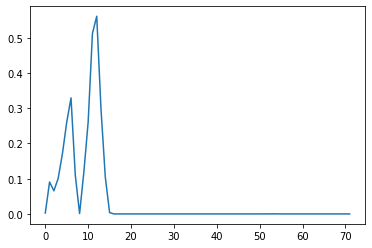

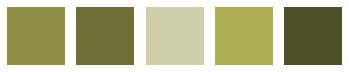

[(0, 1, 4), (0, 1, 3), (0, 0, 6), (0, 1, 5), (0, 1, 2)]


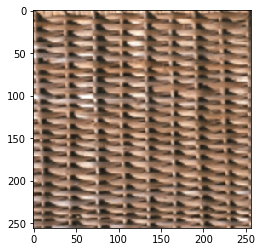

239.0625


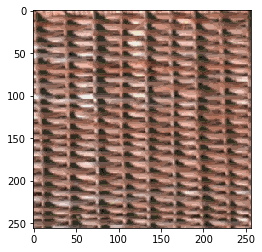

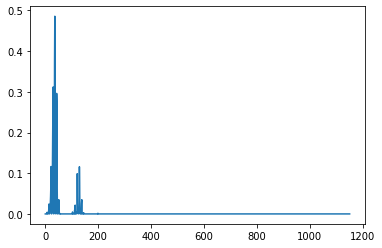

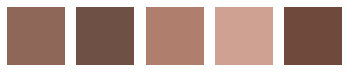

[(0, 4, 4), (0, 4, 3), (0, 4, 5), (0, 3, 6), (0, 5, 3)]


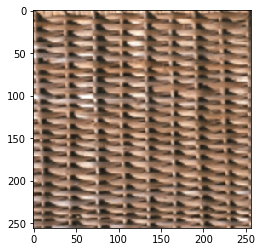

212.49999999999997


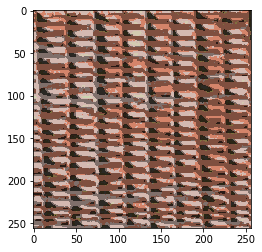

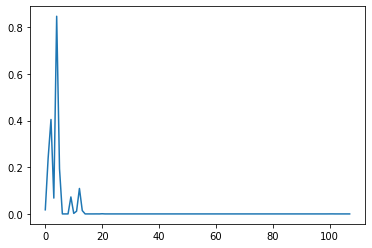

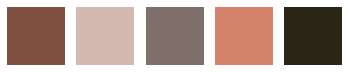

[(0, 1, 1), (0, 0, 2), (0, 0, 1), (0, 1, 2), (1, 1, 0)]


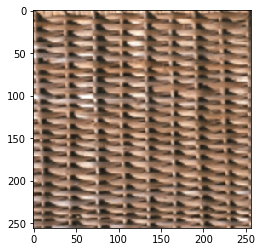

248.625


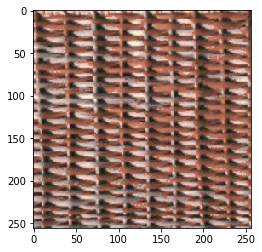

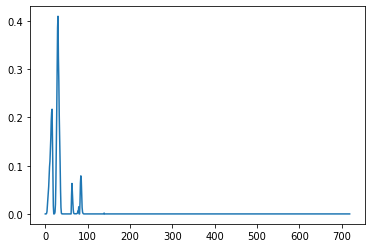

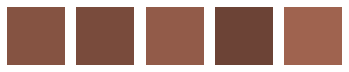

[(0, 1, 10), (0, 1, 9), (0, 1, 11), (0, 1, 8), (0, 1, 12)]


In [7]:
testHSVHistogram(12,3,8,'./Base/','Textures47.png')
testHSVHistogram(3,3,8,'./Base/','Textures47.png')
testHSVHistogram(12,12,8,'./Base/','Textures47.png')
testHSVHistogram(12,3,3,'./Base/','Textures47.png')
testHSVHistogram(12,3,20,'./Base/','Textures47.png')

7) What can you say about the results?

On observe qu'en changeant les valeurs nH, nS et nV, on obtient globalement des histogrammes dont les pics sont situés au même endroit, toutefois en changeant fortement certaines de ces valeurs, la hauteur de ces pics peut beaucoup varier. De plus si on prend des valeurs plus élevées pour nH, nS ou nV, on obtient beaucoup de petits pics au même endroit. À l'inverse, en réduisant ces valeurs, on obtient peu de pics pour un seul endroit dans l'histogramme. Cela est parfaitement logique puisque nH, nS et nV correspondent au nombre d'intervalle que l'on prend pour les valeurs de H,S et V.
On observe aussi qu'en prennant des valeurs trop peu élevées, l'image est beaucoup modifiée (comme c'est le cas dans l'exemple ci-dessus avec "testHSVHistogram(3,3,8,'./Base/','Textures47.png')".
Il faut donc faire attention lorsqu'on choisit ces valeurs car des valeurs trop faibles entraine beaucoup de perte d'information sur l'image qu'on observe. À l'inverse, des valeurs trop élevées modifieront peu l'image mais la méthode que l'on utilise par la suite ne fonctionnera probablement pas très bien car en ayant des valeurs trop précises, l'algorithme ne sera peut-être pas capable de bien reconnaitre les similitudes entre les images.

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the more similar to a given image.

### 2.1 : Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [14]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = 1 # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### 2.2 : Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [9]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

### you code below
def similarityMatrix(listHisto):
    S=np.zeros((1040,1040))
    for i in range(len(listHisto)):
        for j in range(len(listHisto)):
            S[i,j]=np.linalg.norm(listHisto[i]-listHisto[j])
    return S

S=similarityMatrix(listHisto)


2. Display the matrix `S`  as an image. What can we say about this it ?

Premièrement, on voit que la matrice est symétrique, ce qui est logique car comparer on image img1 avec une image img2 revient à la même chose que comparer img2 avec img1.
On voit aussi très clairement une diagonale noir dans la matrice, cette diagonale correspond aux cas où une image est comparé avec elle-même, cette diagonale nous montre que la distance entre une image comparée avec elle-même est nulle.
Enfin, on remarque des carrés foncés le long de la diagonale dans l'affichage de la matrice, cela est dû au fait que les images sont rangées dans un ordre bien précis dans la base de donnée et que globalement les images qui se ressemblent sont rangées ensemble (par exemple, les images de lions, sont rangées juste à cté des autres images de lion puisque les images sont dans l'ordre alphabétique). On peut aussi remarquer certains carrés loin de la diagonale, en reprennant le même raissonement concernant la manière dont sont rangées les images, on peut conclure grâce aux carrés foncés loin de la diagonale que cette méthode confond certaines catégorie d'images avec d'autres catégories d'images.

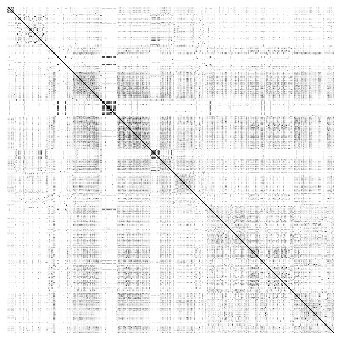

In [10]:
imshow(S)

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

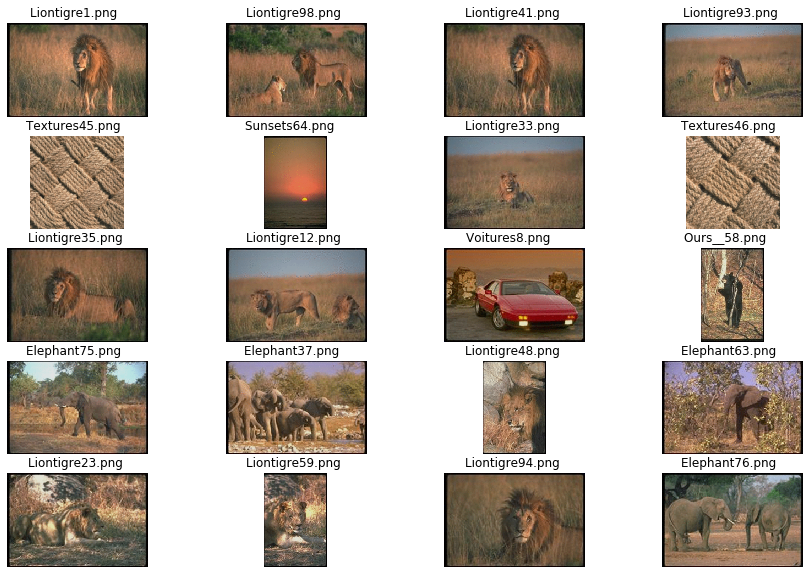

In [11]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


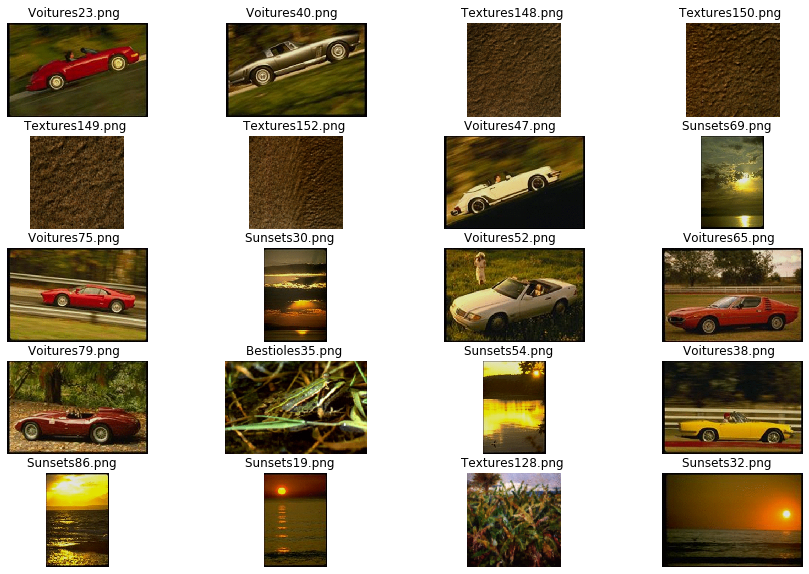

In [12]:
import random

display20bestMatches(S, random.randint(0,1039))
imageName = (pathImage+listImage[indexQuery]).strip()

5. What can you say about the results ? What are the limitations and the advantages of this method ?

Cette méthode fonctionne assez bien sur des images très similaires, comme on peut le voir avec l'image du lion à la question 4.
En effet dans cet exemple une grande partie des images similaires qui sont retournées sont bien des lions.
Toutefois le principal désavantage de cet méthode est qu'elle ne prend en compte que les couleurs des pixels mais pas leurs positions dans l'image. En conséquence, même si 2 images correspondent à des choses très différente, si les couleurs sont très proches, alors elle va considérer qu'elles sont similaires. On le voit très clairement dans l'exemple ci-dessous où le orange du coucher de soleil et le orange des citrouilles est similaire, et que la méthode pense donc que les images sont similaires.

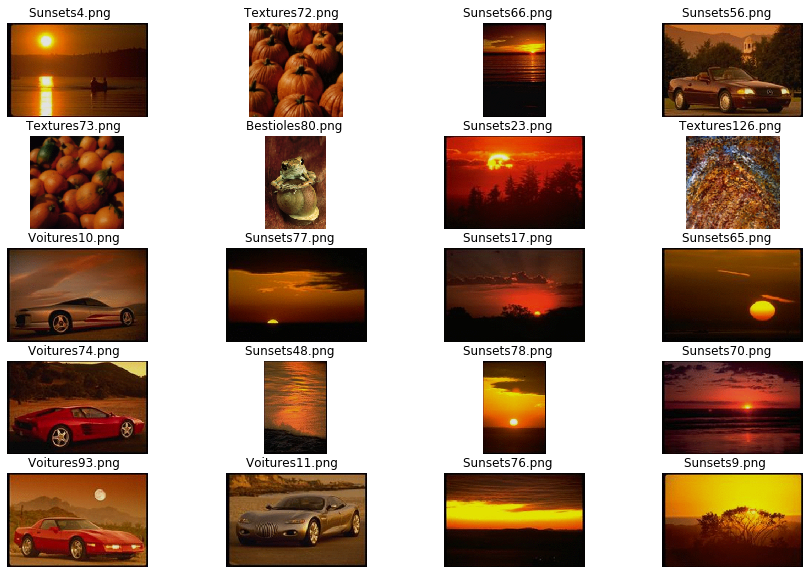

In [13]:
display20bestMatches(S, 699)
imageName = (pathImage+listImage[indexQuery]).strip()